In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import Pool, cv,CatBoostRegressor

In [2]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')
submission_df = pd.read_csv('sample_submission.csv')

In [13]:
data = train_df[train_df['label'] == 1].drop(['label'], axis=1).dropna()

In [14]:
data.columns

Index(['additional_fare', 'duration', 'meter_waiting', 'meter_waiting_fare',
       'meter_waiting_till_pickup', 'fare', 'pickup_date', 'pickup_hour',
       'pickup_minute', 'drop_date', 'drop_hour', 'drop_minute',
       'pick_cluster', 'is_more_than_one_day', 'distance_km', 'fare_per_km',
       'pickup_timeslot', 'day_of_week', 'is_weekday', 'cal_time_difference'],
      dtype='object')

In [5]:
cat_features = ['pick_cluster','is_more_than_one_day','pickup_timeslot',
       'day_of_week', 'is_weekday']

features = [
    'additional_fare',
#     'meter_waiting',
    'meter_waiting_fare',
    'meter_waiting_till_pickup', 
    'pick_cluster', 
    'is_more_than_one_day', 
    'distance_km',
    'pickup_timeslot',
    'day_of_week', 
    'is_weekday',
#     'fare'
]

In [6]:
X = data[features]
y = data['duration'].values

In [7]:
train_df_X = train_df[features]
train_df_pool = Pool(data=train_df_X,cat_features=cat_features)
test_df_X = test_df[features]
test_df_pool = Pool(data=test_df_X,cat_features=cat_features)

In [8]:
train_df_preds = np.zeros(train_df.shape[0])
test_df_preds = np.zeros(test_df.shape[0])

In [9]:
params = {
    'loss_function':'RMSE',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'RMSE'
}

In [10]:
kf = KFold(n_splits=3)

In [11]:
validation_scores = []
models = []
for train_index, test_index in kf.split(X, y):
    X_train, X_test = X.iloc[train_index,:], X.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostRegressor(**params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    validation_score = model.best_score_['validation']['RMSE']
    print('Validation RMSE',validation_score)
    validation_scores.append(validation_score)
    models.append(model)
    
    train_df_preds += model.predict(train_df_pool)
    test_df_preds += model.predict(test_df_pool)

Learning rate set to 0.072878
0:	learn: 5938.5850909	test: 10969.7979817	best: 10969.7979817 (0)	total: 77.5ms	remaining: 1m 17s
10:	learn: 4783.4663285	test: 10065.8823199	best: 10065.8823199 (10)	total: 163ms	remaining: 14.7s
20:	learn: 4027.0228432	test: 9654.7970277	best: 9654.7970277 (20)	total: 276ms	remaining: 12.8s
30:	learn: 3341.1884253	test: 9303.9244701	best: 9303.9244701 (30)	total: 375ms	remaining: 11.7s
40:	learn: 2845.5087793	test: 9127.6706770	best: 9127.6706770 (40)	total: 460ms	remaining: 10.8s
50:	learn: 2404.1179858	test: 8946.9417814	best: 8945.5445557 (49)	total: 579ms	remaining: 10.8s
60:	learn: 2023.1008346	test: 8838.3828441	best: 8838.3828441 (60)	total: 665ms	remaining: 10.2s
70:	learn: 1731.3280360	test: 8776.8984631	best: 8774.0445078 (68)	total: 746ms	remaining: 9.76s
80:	learn: 1490.2977136	test: 8694.8267461	best: 8694.8267461 (80)	total: 869ms	remaining: 9.86s
90:	learn: 1303.2206224	test: 8653.0088827	best: 8651.3564620 (88)	total: 959ms	remaining: 9.

80:	learn: 1201.3364771	test: 5254.7177368	best: 5254.7177368 (80)	total: 861ms	remaining: 9.77s
90:	learn: 1071.1519578	test: 5233.1173692	best: 5231.4122217 (89)	total: 996ms	remaining: 9.95s
100:	learn: 986.3417470	test: 5223.1479391	best: 5222.9969250 (99)	total: 1.11s	remaining: 9.87s
110:	learn: 910.1152008	test: 5218.5558047	best: 5215.1636576 (106)	total: 1.31s	remaining: 10.5s
120:	learn: 851.4789173	test: 5209.2855186	best: 5209.2855186 (120)	total: 1.53s	remaining: 11.1s
130:	learn: 808.3034932	test: 5205.6335571	best: 5204.8268737 (123)	total: 1.72s	remaining: 11.4s
140:	learn: 768.5167866	test: 5205.7263995	best: 5204.7480168 (139)	total: 1.92s	remaining: 11.7s
150:	learn: 740.9077879	test: 5200.7581059	best: 5200.6770693 (149)	total: 2.1s	remaining: 11.8s
160:	learn: 706.1902536	test: 5203.6980139	best: 5200.6770693 (149)	total: 2.29s	remaining: 12s
170:	learn: 688.1955502	test: 5206.8155770	best: 5200.6770693 (149)	total: 2.48s	remaining: 12s
180:	learn: 672.6022561	test

In [12]:
np.mean(validation_scores), np.std(validation_scores)

(5189.101090208857, 2774.2607304883286)

In [41]:
best_model = models[np.argmax(validation_scores)]

In [42]:
best_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,meter_waiting_fare,22.507397
1,is_more_than_one_day,21.421317
2,fare,19.669048
3,distance_km,14.062729
4,meter_waiting,10.652732
5,meter_waiting_till_pickup,4.801282
6,pick_cluster,3.961935
7,additional_fare,2.553974
8,day_of_week,0.155425
9,pickup_timeslot,0.114672


In [43]:
train_df['predicted_duration'] = train_df_preds/3
test_df['predicted_duration'] = test_df_preds/3

In [44]:
train_df['predicted_duration_difference'] = train_df['duration'] - train_df['predicted_duration']
test_df['predicted_duration_difference'] = test_df['duration'] - test_df['predicted_duration']

In [45]:
train_df['predicted_duration_difference_per_duration'] = train_df['predicted_duration_difference'] / (train_df['duration'] + 1)
test_df['predicted_duration_difference_per_duration'] = test_df['predicted_duration_difference'] / (test_df['duration'] + 1)

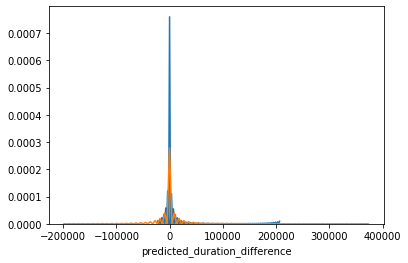

In [46]:
sns.distplot(train_df[train_df['label']==1]['predicted_duration_difference'], hist=False)
sns.distplot(train_df[train_df['label']==0]['predicted_duration_difference'], hist=False)

In [47]:
train_df.to_csv('train_df_reg_duration.csv',index=False)
test_df.to_csv('test_df_reg_duration.csv',index=False)